In [1]:
import keras
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
variablesIndex = [5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
variablesName = ["T", "H", "H2", "O", "O2", "OH", "H2O", "HO2", "H2O2", "CO", "CO2", "CH2O",
                 "HO2CHO", "O2CHO", "CH3O2H", "CH3O2", "CH4", "CH3", "C2H5", "C2H4", "C2H3",
                 "CH3CHO", "C2H5OH", "O2C2H4OH"]

In [3]:
clean_data = []
for j in range(len(variablesIndex)):
  start = time.time()
  clean_data.append(pd.read_csv(
    'drive/My Drive/DNS Autoencoders/plane-xy-0.50.2.200E-03.csv',
    header=None,
    index_col=None,
    skiprows=lambda row: row < (31360 * (variablesIndex[j] - 1) + 37),
    nrows=31360,
    engine='python',
    dtype='float32'
  ))
  stop = time.time()
  print(f'Variable {variablesName[j]} Read in {round(stop-start, 2)}s')

Variable T Read in 9.87s
Variable H Read in 0.66s
Variable H2 Read in 0.76s
Variable O Read in 0.9s
Variable O2 Read in 0.87s
Variable OH Read in 0.98s
Variable H2O Read in 1.19s
Variable HO2 Read in 1.17s
Variable H2O2 Read in 1.19s
Variable CO Read in 1.36s
Variable CO2 Read in 1.27s
Variable CH2O Read in 1.4s
Variable HO2CHO Read in 1.49s
Variable O2CHO Read in 1.46s
Variable CH3O2H Read in 1.54s
Variable CH3O2 Read in 1.74s
Variable CH4 Read in 1.67s
Variable CH3 Read in 1.81s
Variable C2H5 Read in 1.9s
Variable C2H4 Read in 1.83s
Variable C2H3 Read in 1.92s
Variable CH3CHO Read in 2.11s
Variable C2H5OH Read in 2.05s
Variable O2C2H4OH Read in 2.18s


In [4]:
mins, maxs = [], []
for j in range(len(variablesIndex)):
    mins.append(clean_data[j].to_numpy().min())
    maxs.append(clean_data[j].to_numpy().max())
    clean_data[j] = (clean_data[j] - np.full_like(clean_data[j], mins[j])) / (np.full_like(clean_data[j], maxs[j]) - np.full_like(clean_data[j], mins[j]))

In [5]:
for j in range(len(variablesIndex)):
    clean_data[j] = np.array(clean_data[j]).reshape((560, 560))

In [6]:
noisy_data = list(clean_data)
for j in range(len(variablesIndex)):
    noisy_data[j] = noisy_data[j] + 0.05 * np.random.normal(loc=0.0, scale=1.0, size=noisy_data[j].shape)

In [7]:
# stack clean and noisy training images together
clean_stacked_train = np.concatenate(clean_data).reshape((1, len(variablesIndex)*560*560))
noisy_stacked_train = np.concatenate(noisy_data).reshape((1, len(variablesIndex)*560*560))

In [8]:
input_img = keras.layers.Input(shape=(len(variablesIndex)*560*560, ))

In [9]:
x = keras.layers.Dense(10, activation='relu', activity_regularizer=keras.regularizers.l1())(input_img)
x = keras.layers.Dense(7, activation='relu', activity_regularizer=keras.regularizers.l1())(x)
x = keras.layers.Dense(5, activation='relu', activity_regularizer=keras.regularizers.l1())(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(7, activation='relu', activity_regularizer=keras.regularizers.l1())(x)
x = keras.layers.Dense(10, activation='relu', activity_regularizer=keras.regularizers.l1())(x)
x = keras.layers.Dense(len(variablesIndex)*560*560, activation='sigmoid')(x)

In [10]:
autoencoder = keras.Model(input_img, x)
autoencoder.summary()
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7526400)]         0         
_________________________________________________________________
dense (Dense)                (None, 10)                75264010  
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 77        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 40        
_________________________________________________________________
dropout (Dropout)            (None, 5)                 0         
_________________________________________________________________
batch_normalization (BatchNo (None, 5)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 7)                

In [11]:
autoencoder.fit(noisy_stacked_train, noisy_stacked_train, epochs=100, callbacks=[keras.callbacks.EarlyStopping(patience=3, monitor='loss')])
autoencoder.save('drive/My Drive/DNS Autoencoders/bestANN2.200E-03')

Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.7143
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.6931
Epoch 3/100
1/1 [==============================] - 0s 1ms/step - loss: 0.6931
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 0.6931
Epoch 5/100
1/1 [==============================] - 0s 1ms/step - loss: 0.6931
Epoch 6/100
1/1 [==============================] - 0s 3ms/step - loss: 0.6931
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.6931
Epoch 8/100
1/1 [==============================] - 0s 1ms/step - loss: 0.6931
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.6930
Epoch 10/100
1/1 [==============================] - 0s 1ms/step - loss: 0.6930
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.6930
Epoch 12/100
1/1 [==============================] - 0s 1ms/step - loss: 0.6930
Epoch 13/100
1/1 [==============================] - 0s 1ms/st

In [12]:
predicted = np.split(autoencoder.predict(noisy_stacked_train).reshape((len(variablesIndex)*560, 560)), len(variablesIndex))

In [13]:
for j in range(len(variablesIndex)):
  predicted[j] = predicted[j]*(np.full_like(predicted[j], maxs[j]) - np.full_like(predicted[j], mins[j])) + np.full_like(predicted[j], mins[j])
  clean_data[j] =clean_data[j]*(np.full_like(clean_data[j], maxs[j]) - np.full_like(clean_data[j], mins[j])) + np.full_like(clean_data[j], mins[j])
  noisy_data[j] =noisy_data[j]*(np.full_like(noisy_data[j], maxs[j]) - np.full_like(noisy_data[j], mins[j])) + np.full_like(noisy_data[j], mins[j])

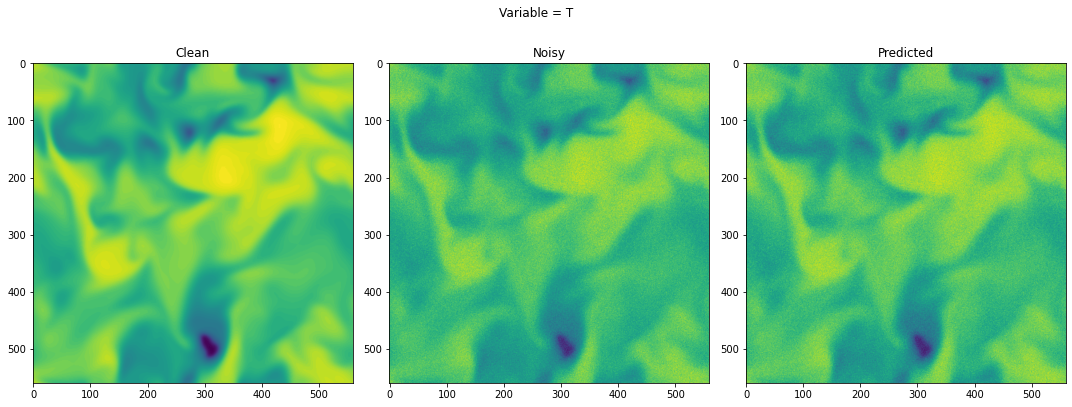

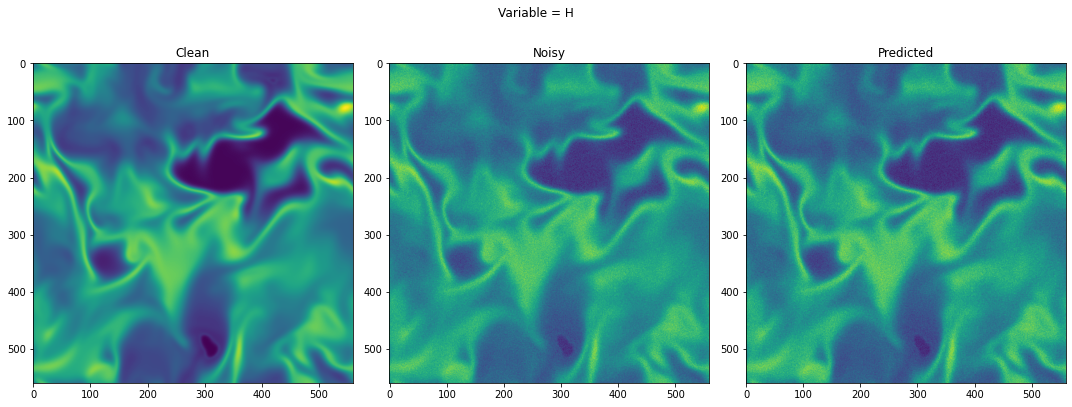

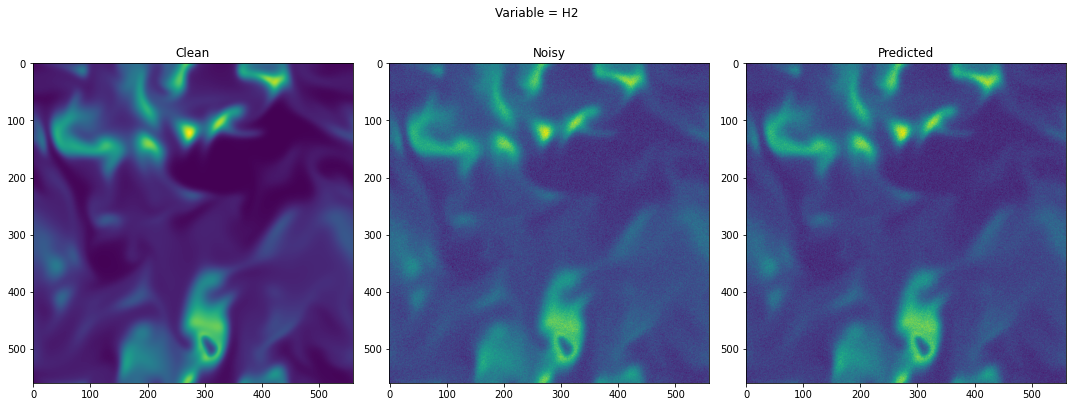

In [ ]:
for j in range(len(variablesIndex)):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))
  fig.suptitle(f'Variable = {variablesName[j]}', y=0.8)
  
  ax1.set_title("Clean")
  ax1.imshow(clean_data[j])
  
  ax2.set_title("Noisy")
  ax2.imshow(noisy_data[j])

  ax3.set_title("Predicted")
  ax3.imshow(predicted[j])

  plt.savefig(f'drive/My Drive/DNS Autoencoders/2.200E-03 Results/{variablesName[j]}.tiff')
  plt.tight_layout()

  plt.show()